# MACD Analysis and Buy/Sell Signals


> MACD, short for moving average convergence/divergence, is a trading indicator used in technical analysis of stock prices. 
Source: https://en.wikipedia.org/wiki/MACD

We analyse stock data using MACD and generate buy and sell signals.

In [17]:
# Parameters for MACD computation

# fast_window: window length of the fast EMA 
# slow_window: window length of the slow EMA
# signal_window: window length of the signal EMA

fast_window = 12
slow_window = 26
signal_window = 9

# stock's data as csv file from ariva.de
input_data_file = '../data/external/data.csv'

# notebook stores the result in output_data_path
output_data_path = '../data/interim'

# notebook name; required for outfile naming convention
# Can't be acquired by javascript approaches when 'run all'
# see: https://github.com/jupyter/notebook/issues/1622
nb_file = 'MACD_BuySell'

#### Some installs and imports

In [2]:
# Install a pip module in the current Jupyter kernel
import sys

try:
    from stockstats import StockDataFrame as Sdf
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install stockstats

try:   
    import seaborn as sns
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install seaborn
    
try:
    import papermill as pm
except ImportError as err:
    print("Handling run-time error: ", err)
    print("Will now install missing module.")
    !{sys.executable} -m pip install papermill


In [3]:
# other imports

# manipulating data
import pandas as pd
import numpy as np
from stockstats import StockDataFrame as Sdf

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.style as style 

# notebook parameterizing and automation 
import papermill as pm

## MACD Function using Parameters

Below there is an example of MACD calculation:

    The MACD line (macd): 12-day EMA - 26-day EMA
    Signal Line (macds): 9-day EMA of MACD Line

The parameter are (fast, slow, signal) = (12, 26, 9). 
We generalize the example above and compute the parameterize MACD as follows:

\begin{align}
MACD^{fast, slow}(t) & = EMA^{fast}(close, t) - EMA^{slow}(close, t) \\
Signal^{sig}(t) & = EMA^{sig}(MACD^{fast, slow}(t), t) \\
\end{align}

In [4]:
#
# original from stockstats source
# modified to paramterize it
#

def macd_params(df, fast_window=12, slow_window=26, signal_window=9):
    """ Moving Average Convergence Divergence

    This function will initialize all following columns.

    MACD Line (macd): (fast_window EMA - slow_window EMA)
    Signal Line (macds): signal_window EMA of MACD Line
    MACD Histogram (macdh): MACD Line - Signal Line
    
    :param df: data
    :param fast_window: window length of the fast EMA 
    :param slow_window: window length of the slow EMA
    :param signal_window: window length of the signal EMA
    
    :return: None
    """
    
    # parameter check
    if (fast_window > slow_window) or (signal_window > fast_window):
        # error
        raise ValueError('Parameter values do not fit.')
    
    fast = df['close_' + str(fast_window) + '_ema']
    slow = df['close_' + str(slow_window) + '_ema']
    df['macd'] = fast - slow
    df['macds'] = df['macd_' + str(signal_window) + '_ema']
    df['macdh'] = (df['macd'] - df['macds'])

    del df['macd_' + str(signal_window) + '_ema']
    del fast
    del slow
    
    

## Data Import

The data download is from ariva.de. The import adjust some formatting in order to work with python's `stockstats` package. 

* delimiter is ';'
* header line uses english idenifiers
* decimal separator is specified as ','
* thousands separator is '.'

In [5]:
# Path to data is in parameter 'data_file'

# import data
colnames = ['date', 'open', 'high', 'low', 'close', 'shares', 'volume']
data = pd.read_csv(input_data_file, delimiter=';', header=0, names=colnames, decimal=',', thousands='.')
stock  = Sdf.retype(data)

# sort by date ascending 
stock.sort_index(ascending=True, inplace=True)

## Data Visualization

Let's quickly have an overview about the stock data.

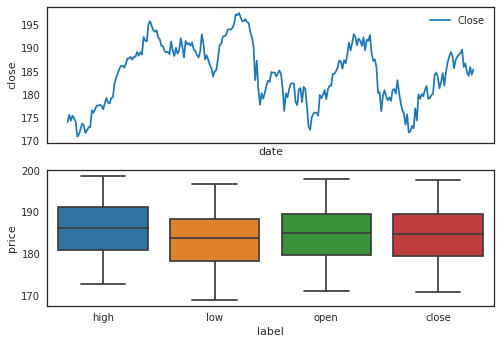

In [6]:
# reset the index to use it as x-axis data
stock.reset_index(inplace=True)
# reindex the dataframe
stock.index = [stock['date']]

style.use('seaborn-notebook')
style.use('seaborn-white')

# 2x1 plot
stock_fig = plt.figure()
stock_fig1 = stock_fig.add_subplot(211) # 3x1, fig.1
stock_fig2 = stock_fig.add_subplot(212) # 3x1, fig.2

# line plot for close
sns.lineplot(data=stock, x='date', y='close', label='Close', ax=stock_fig1)
# remove ticks and labels 
stock_fig1.tick_params(labelbottom=False, bottom=False)

# box plot for open, close, high, low
stock_prices = pd.DataFrame({'price': stock['high'], 'label': 'high'})
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['low'], 'label': 'low'})], sort=False)
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['open'], 'label': 'open'})], sort=False)
stock_prices = pd.concat([stock_prices, pd.DataFrame({'price': stock['close'], 'label': 'close'})], sort=False)
sns.boxplot(x="label", y="price", data=stock_prices)

## Compute MACD and Visualize

In [7]:
# compute macd with standard param (12 / 26 / 9)
macd_params(stock, fast_window, slow_window, signal_window)

In [8]:
stock.head()

,date,open,high,low,close,shares,volume,close_12_ema,close_26_ema,macd,macds,macdh
date,,,,,,,,,,,,
2017-08-21,2017-08-21,174.3375,175.6815,173.1374,174.0495,776936,135380672,174.049500,174.049500,0.000000,0.000000,0.000000
2017-08-22,2017-08-22,175.2015,176.1615,174.8655,175.5855,714906,125526592,174.881500,174.847038,0.034462,0.019145,0.015316
2017-08-23,2017-08-23,175.5375,176.0655,174.0014,174.3375,800080,139733784,174.669177,174.663966,0.005210,0.013434,-0.008224
2017-08-24,2017-08-24,174.4815,176.5935,174.4815,175.4415,725802,127510400,174.912969,174.881331,0.031638,0.019601,0.012037
2017-08-25,2017-08-25,175.3455,176.3535,174.8175,174.9135,673465,118082856,174.913113,174.888791,0.024322,0.021005,0.003317


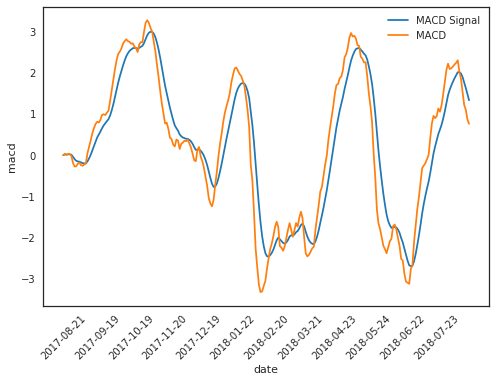

In [9]:
# visualize MACD and MACD signal
style.use('seaborn-notebook')
style.use('seaborn-white')

#stock.reset_index(inplace=True)
sns.lineplot(data=stock, x='date', y='macds', label='MACD Signal')
sns.lineplot(data=stock, x='date', y='macd', label='MACD')
l=stock.date.count()/12
plt.xticks(stock.date[0::int(l)], rotation=45)
plt.show()

## Compute Buy/Sell Signals

The buy/sell signals are the result when the MACD and the MACD-Signal cross each other.

* MACD - Moving Average Convergence/Divergence
* MACD Signal - EMA of MACD

**BUY** Signal: $ MACD(t-1) < Signal(t-1) \textrm{ and } MACD(t) > Signal(t) $ <br>
**SELL** Signal: $ MACD(t-1) > Signal(t-1) \textrm{ and } MACD(t) < Signal(t) $ <br>
**HOLD** Signal: else

**Note:** In the code below the variable are assigned 

* MACD -> macd
* MACD Signal -> macds
* BUY/SELL/HOLD -> signal

Finally, complement the dataframe with buy/sell/hold signal. 

In [10]:
macd = stock['macd']
macds = stock['macds']
macd.sort_index(ascending=True, inplace=True)
macds.sort_index(ascending=True, inplace=True)

# sort stock ascending and reset to standard integer index
stock.sort_index(ascending=True, inplace=True)
stock.reset_index(inplace=True, drop=True)
stock['signal'] = ""
stock.at[0, 'signal']="No data"

for t in range(1, len(macds)):
    #                          # If the MACD crosses the signal line upward
    if macd[t - 1] < macds[t - 1] and macd[t] > macds[t]:
        stock.at[t, 'signal']="BUY"
    #                          # The other way around
    elif macd[t - 1] > macds[t - 1] and macd[t] < macds[t]:
        stock.at[t, 'signal']="SELL"
    #                          # Do nothing if not crossed
    else:
        stock.at[t, 'signal']="HOLD"

## Visualize all Data

Plot the MACD, MACD signal and the buy/sell/hold signals.

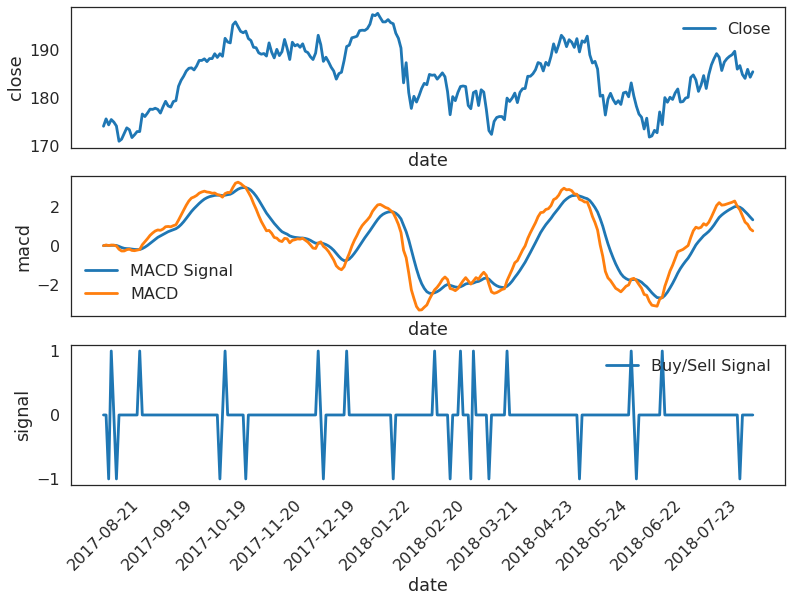

In [11]:
# replace BUY/SELL/HOLD by 1/-1/0 for plotting
stock['signal'] = stock['signal'].replace('BUY', 1).replace('SELL', -1).replace('HOLD', 0).replace('No data', 0)

# set plot style
style.use('seaborn-poster')
style.use('seaborn-white')

# Create a figure instance, and the two subplots
fig = plt.figure()
ax1 = fig.add_subplot(311) # 3x1, fig.1
ax2 = fig.add_subplot(312) # 3x1, fig.2
ax3 = fig.add_subplot(313) # 3x1, fig.3

# Stock data
sns.lineplot(data=stock, x='date', y='close', label='Close', ax=ax1)
# MACD, MACD Signal 
sns.lineplot(data=stock, x='date', y='macds', label='MACD Signal', ax=ax2)
sns.lineplot(data=stock, x='date', y='macd', label='MACD', ax=ax2)
# Buy/Sell Signal
sns.lineplot(data=stock, x='date', y='signal', label='Buy/Sell Signal', ax=ax3)

# remove ticks and labels 
ax1.tick_params(labelbottom=False, bottom=False)
ax2.tick_params(labelbottom=False, bottom=False)   

# format ticks
l=stock.date.count()/12
plt.xticks(stock.date[0::int(l)], rotation=45)
plt.show()

## Stats and Data stored for later Use

We store some statistics data.
Additionally, we record values in the notebook using Papermill to be consumed by other notebooks later on.

In [12]:
# compute stats
BUY_cnt = stock[stock['signal']==1].shape[0]
SELL_cnt = stock[stock['signal']==-1].shape[0]
HOLD_cnt = stock[stock['signal']==0].shape[0]
STATS = stock.describe()
# print stats
print("BUY Signals: ", BUY_cnt)
print("SELL Signals: ", SELL_cnt)
print("HOLD Signals: ", HOLD_cnt)
print("Statistics:")
print(STATS)

BUY Signals:  11
SELL Signals:  12
HOLD Signals:  229
Statistics:
             open        high         low       close        shares  \
count  252.000000  252.000000  252.000000  252.000000  2.520000e+02   
mean   184.629700  185.828262  183.221285  184.497138  1.323365e+06   
std      6.438659    6.375852    6.556162    6.482004  5.376838e+05   
min    171.073400  172.897400  169.057400  170.929400  6.302010e+05   
25%    179.698575  181.010000  178.225500  179.375100  1.015912e+06   
50%    185.070300  186.094400  183.720000  184.810350  1.212792e+06   
75%    189.457200  191.262400  188.365600  189.436000  1.436933e+06   
max    197.953600  198.577700  196.753600  197.521600  4.478718e+06   

             volume  close_12_ema  close_26_ema        macd       macds  \
count  2.520000e+02    252.000000    252.000000  252.000000  252.000000   
mean   2.438393e+08    184.247229    184.007997    0.239232    0.217932   
std    9.737240e+07      5.889254      5.303585    1.775688    1.6203

In [18]:
# csv file naming convention
# <nb_name>_<data_name>_<fast>_<slow>_<signal>.csv

import os
data_name = os.path.basename(input_data_file).replace('.csv','')
nb_name = os.path.basename(nb_file).replace('.ipynb','')
csv = nb_name + '_' + data_name + '_' + str(fast_window) + '_' + str(slow_window) + '_' + str(signal_window) + '.csv'

In [ ]:
# here, we record the data for later use

pm.record("csv", csv)

# We don't need them, because pm stores parameters anyway
#pm.record("fast_window", fast_window)
#pm.record("slow_window", slow_window)
#pm.record("signal_window", signal_window)

## Save Results as CSV

We store the complete dataframe in the `output_data_path` directory.

In [19]:
csv_file = os.path.join(output_data_path, csv )
stock.to_csv(csv_file, sep=';')
#csv_file

'../data/interim/MACD_BuySell_data_12_26_9.csv'